In [73]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers
import shap

C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
EMPRESA = 'WEGE3.SA'

In [47]:
def get_data_ticker(ticker, period='5y'):
    data_hist = yf.download(ticker, period=period)
    data_hist = pd.DataFrame(data_hist['Close'])
    data_hist['prev-day-1'] = data_hist['Close'].shift(1)
    data_hist['prev-day-2'] = data_hist['Close'].shift(2)
    data_hist['prev-day-3'] = data_hist['Close'].shift(3)
    data_hist['mm_5'] = data_hist['Close'].rolling(5).mean()
    data_hist['mm_21'] = data_hist['Close'].rolling(21).mean()
    data_hist = data_hist.dropna()
    data_hist['tomorrow'] = data_hist['Close'].shift(-1)
    return data_hist

In [48]:
def split_df_X_y(df_model):
    dates = df_model.index
    df_as_np = df_model.to_numpy()
    X = df_as_np[:,:-1]

    X = X.reshape(len(dates), X.shape[1])
    y = df_as_np[:,-1]

    return (dates, X.astype(np.float32), y.astype(np.float32))

df_full = get_data_ticker(EMPRESA, period='5y')
df = df_full.dropna()
dates, X, y = split_df_X_y(df)

[*********************100%%**********************]  1 of 1 completed


In [77]:
def train_model_lstm(X_train, y_train, X_test, y_test):
    model = Sequential([layers.Input((6,1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)
    return model

def train_model_feedforward(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(layers.Dense(64, activation='relu', input_dim=6))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)
    return model

def train_model_rnn(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(layers.Input((6,1)))
    model.add(layers.SimpleRNN(40, return_sequences=True))
    model.add(layers.SimpleRNN(40))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)
    return model

def train_model_cnn(X_train, y_train, X_test, y_test):
    # Create a CNN model
    model = Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(6, 1)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)
    return model

In [50]:
def predict_tomorrow(model):
    last_day = get_data_ticker(EMPRESA, period='1mo') # Buscando um mes de dados pois as vezes quando coloco '1d' vem vazio :(
    date_tomorrow, X_tomorrow, y_tomorrow = split_df_X_y(last_day)
    return model.predict(np.array([X_tomorrow[-1]]))


In [51]:
range_80 = int(len(dates)*.85)
range_90 = int(len(dates)*.95)

dates_train, X_train, y_train = dates[:range_80], X[:range_80], y[:range_80]
dates_test, X_test, y_test = dates[range_80:range_90], X[range_80:range_90], y[range_80:range_90]
dates_validation, X_validation, y_validation = dates[range_90:], X[range_90:], y[range_90:]

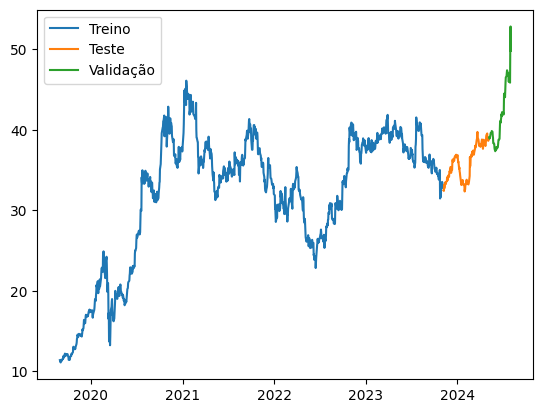

In [52]:
plt.plot(dates_train,y_train, label='Treino')
plt.plot(dates_test,y_test, label='Teste')
plt.plot(dates_validation,y_validation, label='Validação')
plt.legend()

## Treinamento da LSTM

## Resultado com dados nunca vistos pelo modelo

#### LSTM

In [53]:
model_lstm = train_model_lstm(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_lstm)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 956.1844 - mean_absolute_error: 29.6579 - val_loss: 676.1989 - val_mean_absolute_error: 25.9014
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 361.3691 - mean_absolute_error: 16.6461 - val_loss: 7.0963 - val_mean_absolute_error: 2.2387
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 66.8487 - mean_absolute_error: 6.2008 - val_loss: 17.7438 - val_mean_absolute_error: 3.7849
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.3688 - mean_absolute_error: 3.1096 - val_loss: 0.7504 - val_mean_absolute_error: 0.6870
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0197 - mean_absolute_error: 1.0750 - val_loss: 0.7420 - val_mean_absolute_error: 0.6646
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9332 - mean_absolute_error: 1.0758 - val_loss: 1.2400 - val_mean_absolute_error: 0.9082
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8203 - mean_absolute_error: 0.99

[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


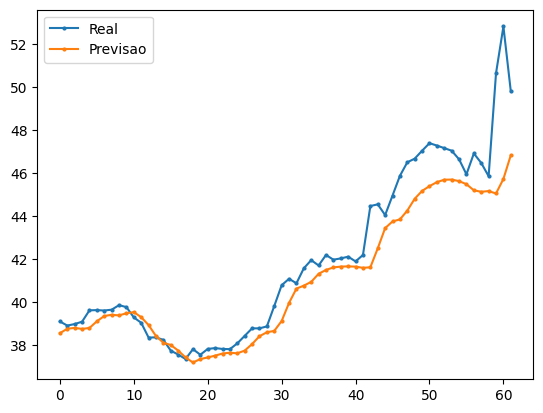

In [85]:
y_pred = model_lstm.predict(X_validation).flatten()
# y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real",marker='o', markersize=2)
plt.plot(pd.Series(y_pred), label="Previsao",marker='o', markersize=2)
plt.legend()

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Using 1040 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/122 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


  1%|          | 1/122 [00:05<11:11,  5.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


  2%|▏         | 2/122 [00:11<11:30,  5.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


  2%|▏         | 3/122 [00:17<11:50,  5.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


  3%|▎         | 4/122 [00:24<12:20,  6.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


  4%|▍         | 5/122 [00:30<11:53,  6.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


  5%|▍         | 6/122 [00:35<11:27,  5.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


  6%|▌         | 7/122 [00:41<11:14,  5.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


  7%|▋         | 8/122 [00:47<11:16,  5.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


  7%|▋         | 9/122 [00:54<11:34,  6.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


  8%|▊         | 10/122 [01:00<11:44,  6.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


  9%|▉         | 11/122 [01:07<11:46,  6.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 10%|▉         | 12/122 [01:13<11:22,  6.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


 11%|█         | 13/122 [01:19<11:29,  6.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 11%|█▏        | 14/122 [01:25<11:08,  6.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


 12%|█▏        | 15/122 [01:32<11:31,  6.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step


 13%|█▎        | 16/122 [01:45<14:48,  8.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


 14%|█▍        | 17/122 [01:54<15:07,  8.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 15%|█▍        | 18/122 [02:00<13:24,  7.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 16%|█▌        | 19/122 [02:05<11:53,  6.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


 16%|█▋        | 20/122 [02:12<11:48,  6.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


 17%|█▋        | 21/122 [02:20<12:04,  7.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


 18%|█▊        | 22/122 [02:26<11:44,  7.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


 19%|█▉        | 23/122 [02:33<11:27,  6.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 20%|█▉        | 24/122 [02:38<10:20,  6.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 20%|██        | 25/122 [02:43<09:30,  5.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 21%|██▏       | 26/122 [02:48<09:06,  5.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 22%|██▏       | 27/122 [02:53<08:35,  5.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 23%|██▎       | 28/122 [02:58<08:29,  5.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 24%|██▍       | 29/122 [03:04<08:17,  5.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


 25%|██▍       | 30/122 [03:09<08:22,  5.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


 25%|██▌       | 31/122 [03:17<09:31,  6.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 26%|██▌       | 32/122 [03:23<09:03,  6.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 27%|██▋       | 33/122 [03:29<08:45,  5.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


 28%|██▊       | 34/122 [03:35<08:47,  5.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 29%|██▊       | 35/122 [03:40<08:10,  5.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


 30%|██▉       | 36/122 [03:47<08:48,  6.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 30%|███       | 37/122 [03:52<08:27,  5.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 31%|███       | 38/122 [03:58<08:00,  5.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 32%|███▏      | 39/122 [04:03<07:55,  5.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


 33%|███▎      | 40/122 [04:11<08:37,  6.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 34%|███▎      | 41/122 [04:16<07:57,  5.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


 34%|███▍      | 42/122 [04:22<08:00,  6.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


 35%|███▌      | 43/122 [04:30<08:35,  6.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 36%|███▌      | 44/122 [04:35<07:48,  6.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 37%|███▋      | 45/122 [04:40<07:32,  5.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 38%|███▊      | 46/122 [04:46<07:24,  5.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


 39%|███▊      | 47/122 [04:54<07:55,  6.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


 39%|███▉      | 48/122 [05:02<08:24,  6.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 40%|████      | 49/122 [05:06<07:35,  6.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


 41%|████      | 50/122 [05:12<07:19,  6.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


 42%|████▏     | 51/122 [05:21<08:03,  6.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


 43%|████▎     | 52/122 [05:27<07:53,  6.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


 43%|████▎     | 53/122 [05:35<07:59,  6.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


 44%|████▍     | 54/122 [05:41<07:43,  6.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


 45%|████▌     | 55/122 [05:48<07:26,  6.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


 46%|████▌     | 56/122 [05:54<07:18,  6.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


 47%|████▋     | 57/122 [06:01<07:09,  6.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 48%|████▊     | 58/122 [06:06<06:36,  6.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 48%|████▊     | 59/122 [06:11<06:02,  5.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


 49%|████▉     | 60/122 [06:17<06:04,  5.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


 50%|█████     | 61/122 [06:23<06:06,  6.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


 51%|█████     | 62/122 [06:29<06:01,  6.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 52%|█████▏    | 63/122 [06:34<05:37,  5.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 52%|█████▏    | 64/122 [06:39<05:17,  5.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 53%|█████▎    | 65/122 [06:44<05:06,  5.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 54%|█████▍    | 66/122 [06:49<04:59,  5.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


 55%|█████▍    | 67/122 [06:57<05:22,  5.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


 56%|█████▌    | 68/122 [07:02<05:14,  5.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


 57%|█████▋    | 69/122 [07:09<05:17,  5.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


 57%|█████▋    | 70/122 [07:16<05:40,  6.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 58%|█████▊    | 71/122 [07:22<05:20,  6.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


 59%|█████▉    | 72/122 [07:29<05:21,  6.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 60%|█████▉    | 73/122 [07:34<04:54,  6.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 61%|██████    | 74/122 [07:39<04:39,  5.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


 61%|██████▏   | 75/122 [07:46<04:43,  6.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


 62%|██████▏   | 76/122 [07:52<04:39,  6.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 63%|██████▎   | 77/122 [07:58<04:27,  5.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 64%|██████▍   | 78/122 [08:03<04:12,  5.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 65%|██████▍   | 79/122 [08:08<03:57,  5.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 66%|██████▌   | 80/122 [08:13<03:44,  5.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


 66%|██████▋   | 81/122 [08:19<03:51,  5.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 67%|██████▋   | 82/122 [08:24<03:40,  5.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 68%|██████▊   | 83/122 [08:29<03:28,  5.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 69%|██████▉   | 84/122 [08:34<03:16,  5.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


 70%|██████▉   | 85/122 [08:41<03:27,  5.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


 70%|███████   | 86/122 [08:49<03:46,  6.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 71%|███████▏  | 87/122 [08:54<03:31,  6.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 72%|███████▏  | 88/122 [08:59<03:15,  5.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 73%|███████▎  | 89/122 [09:04<03:03,  5.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 74%|███████▍  | 90/122 [09:09<02:51,  5.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


 75%|███████▍  | 91/122 [09:18<03:17,  6.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 75%|███████▌  | 92/122 [09:24<03:07,  6.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


 76%|███████▌  | 93/122 [09:30<02:58,  6.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 77%|███████▋  | 94/122 [09:35<02:42,  5.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 78%|███████▊  | 95/122 [09:41<02:36,  5.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


 79%|███████▊  | 96/122 [09:49<02:52,  6.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step


 80%|███████▉  | 97/122 [10:02<03:29,  8.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step


 80%|████████  | 98/122 [10:14<03:49,  9.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step


 81%|████████  | 99/122 [10:27<04:05, 10.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step


 82%|████████▏ | 100/122 [10:40<04:11, 11.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step


 83%|████████▎ | 101/122 [10:53<04:08, 11.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step


 84%|████████▎ | 102/122 [11:06<04:02, 12.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step


 84%|████████▍ | 103/122 [11:19<03:53, 12.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step


 85%|████████▌ | 104/122 [11:31<03:43, 12.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step


 86%|████████▌ | 105/122 [11:44<03:31, 12.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step


 87%|████████▋ | 106/122 [11:56<03:18, 12.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step


 88%|████████▊ | 107/122 [12:10<03:10, 12.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


 89%|████████▊ | 108/122 [12:21<02:52, 12.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


 89%|████████▉ | 109/122 [12:32<02:35, 11.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step


 90%|█████████ | 110/122 [12:45<02:25, 12.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step


 91%|█████████ | 111/122 [12:57<02:13, 12.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step


 92%|█████████▏| 112/122 [13:10<02:04, 12.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step


 93%|█████████▎| 113/122 [13:23<01:52, 12.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step


 93%|█████████▎| 114/122 [13:35<01:38, 12.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step


 94%|█████████▍| 115/122 [13:47<01:27, 12.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


 95%|█████████▌| 116/122 [13:56<01:07, 11.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


 96%|█████████▌| 117/122 [14:06<00:54, 10.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


 97%|█████████▋| 118/122 [14:12<00:38,  9.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


 98%|█████████▊| 119/122 [14:19<00:25,  8.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


 98%|█████████▊| 120/122 [14:26<00:16,  8.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


 99%|█████████▉| 121/122 [14:31<00:07,  7.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2015/2015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


100%|██████████| 122/122 [14:36<00:00,  7.18s/it]


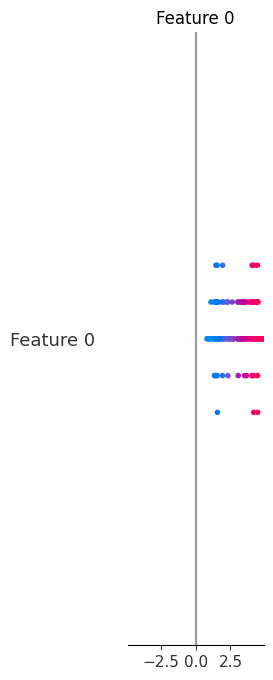

In [74]:
explainer = shap.KernelExplainer(model_lstm.predict, X_train)
shap_values = explainer.shap_values(X_test)

# Plotar os valores SHAP para as features
shap.summary_plot(shap_values, X_test, plot_type="bar")

#### feedforward

In [55]:
model_feedforward = train_model_feedforward(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_feedforward)

Epoch 1/100


C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 922.0374 - mean_absolute_error: 27.2048 - val_loss: 4.0547 - val_mean_absolute_error: 1.9214
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6410 - mean_absolute_error: 2.6896 - val_loss: 1.7566 - val_mean_absolute_error: 1.1733
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7517 - mean_absolute_error: 1.0192 - val_loss: 0.4344 - val_mean_absolute_error: 0.5180
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1060 - mean_absolute_error: 0.7657 - val_loss: 0.4087 - val_mean_absolute_error: 0.5055
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1759 - mean_absolute_error: 0.7898 - val_loss: 0.4144 - val_mean_absolute_error: 0.5085
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1257 - mean_absolute_error: 0.7738 - val_loss: 0.4153 - val_mean_absolute_error: 0.5085
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9273 - mean_absolute_error: 0.7186 - val_loss: 0.3787 

[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


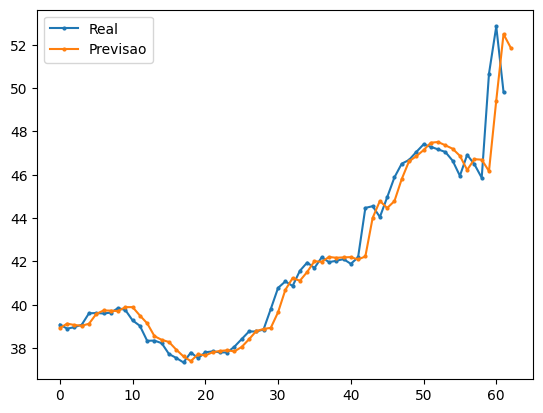

In [92]:
y_pred = model_feedforward.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real",marker='o', markersize=2)
plt.plot(pd.Series(y_pred), label="Previsao",marker='o', markersize=2)
plt.legend()

#### RNN

In [57]:
model_rnn = train_model_rnn(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_rnn)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 987.1528 - mean_absolute_error: 30.2616 - val_loss: 880.5548 - val_mean_absolute_error: 29.5964
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 669.7506 - mean_absolute_error: 24.5438 - val_loss: 757.6994 - val_mean_absolute_error: 27.4427
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 593.3455 - mean_absolute_error: 22.9224 - val_loss: 672.7952 - val_mean_absolute_error: 25.8496
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 532.0531 - mean_absolute_error: 21.5474 - val_loss: 601.5491 - val_mean_absolute_error: 24.4326
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 468.9611 - mean_absolute_error: 20.1245 - val_loss: 538.8667 - val_mean_absolute_error: 23.1143
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 420.3692 - mean_absolute_error: 18.9134 - val_loss: 482.6115 - val_mean_absolute_error: 21.8636
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 365.3798 -

[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


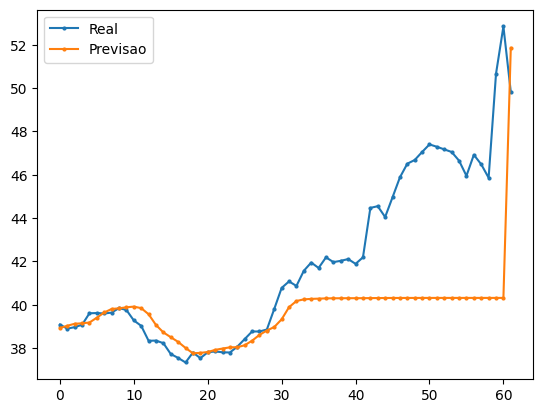

In [69]:
y_pred = model_rnn.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real",marker='o', markersize=2)
plt.plot(pd.Series(y_pred).shift(-1), label="Previsao",marker='o', markersize=2)
plt.legend()

#### CNN

In [59]:
model_cnn = train_model_cnn(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_cnn)

Epoch 1/100


C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 589.2592 - mean_absolute_error: 21.4107 - val_loss: 15.6938 - val_mean_absolute_error: 3.8999
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7637 - mean_absolute_error: 2.6532 - val_loss: 1.5128 - val_mean_absolute_error: 1.0736
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3507 - mean_absolute_error: 0.8486 - val_loss: 0.4873 - val_mean_absolute_error: 0.5545
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0805 - mean_absolute_error: 0.7581 - val_loss: 0.4811 - val_mean_absolute_error: 0.5505
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0699 - mean_absolute_error: 0.7749 - val_loss: 0.4568 - val_mean_absolute_error: 0.5339
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2060 - mean_absolute_error: 0.7898 - val_loss: 0.4526 - val_mean_absolute_error: 0.5309
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0973 - mean_absolute_error: 0.7664 - val_loss: 0.4497

[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


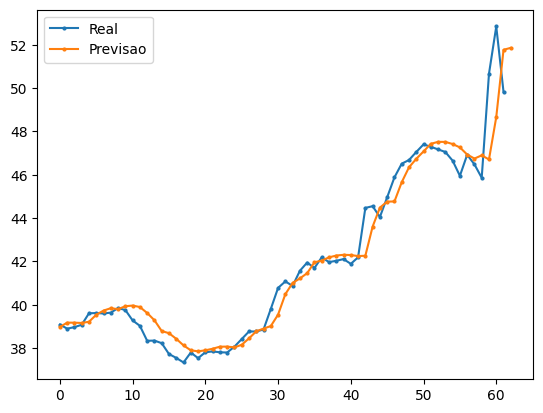

In [94]:
y_pred = model_cnn.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real",marker='o', markersize=2)
plt.plot(pd.Series(y_pred), label="Previsao",marker='o', markersize=2)
plt.legend()